<a href="https://colab.research.google.com/github/the-faisalahmed/Optimization/blob/main/Doctor_Planning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](https://dmcommunity.org/wp-content/uploads/2020/04/doctorplanning.jpg)

In [ ]:
%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

!pip install pyomo
from pyomo.environ import *
from pyomo.opt import SolverFactory
from pyomo.util.infeasible import log_infeasible_constraints
from pyomo.opt import SolverStatus
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
from pyomo.contrib.latex_printer import latex_printer

In [311]:
model = ConcreteModel()

# Doctor
model.I = ['Fleming', 'Freud', 'Heimlech', 'Eustachi', 'Golgi']

# Days
model.J = RangeSet(1,7)
# Shifts
model.K = RangeSet(1,3)

model.X = Var(model.I, model.J, model.K, within = Binary)

def con0_rule(model, j,k):
  return sum(model.X[i,j,k] for i in model.I) >= 1
model.con0 = Constraint(model.J, model.K, rule = con0_rule)

def con1_rule(model,i,j):
  return sum(model.X[i,j,k] for k in model.K) <= 1
model.con1 = Constraint(model.I , model.J, rule = con1_rule)

def con2_1_rule(model,i,j):
  return sum(model.X[i, j, k] for k in model.K) == 0
model.con2_1 = Constraint(['Fleming'], [1,2,3,4], rule = con2_1_rule)

def con2_2_rule(model,i):
  return sum(model.X[i, j, 3] for j in model.J) == 0
model.con2_2 = Constraint(['Freud'], rule = con2_2_rule)

def con2_3_rule(model,i,j):
  return sum(model.X[i, j, k] for k in model.K if k == 3) == 0
model.con2_3 = Constraint(['Heimlech'],[6,7], rule = con2_3_rule)

def con2_4_rule(model,i):
  return sum(model.X[i, j, k] for j in model.J for k in model.K if k == 3) <= 2
model.con2_4 = Constraint(['Golgi'], rule = con2_4_rule)

model.con3 = ConstraintList()
for i in model.I:
  for j in model.J:
    if j != 7:
      model.con3.add(sum(model.X[i,j+1,k] for k in model.K) + model.X[i,j+1,3] <= model.X[i,j,3] + 1)

def con4_rule(model, i,j):
  if j == 6:
    return sum(model.X[i,j,k] for k in model.K) == sum(model.X[i,j+1,k] for k in model.K)
  else:
    return Constraint.Skip
model.con4 = Constraint(model.I, model.J, rule = con4_rule)

def extra_rule(model,i):
  return sum(model.X[i,j,k] for j in model.J for k in model.K) >= 1

model.extra = Constraint(model.I, rule = extra_rule)

def obj_rule(model):
  return sum(model.X[i,j,k] for i in model.I for j in model.J for k in model.K)
model.obj = Objective(rule = obj_rule, sense = maximize)

In [ ]:
#model.pprint()

In [312]:
# Solve model
opt = SolverFactory('cbc')
result = opt.solve(model)

if (result.solver.status == SolverStatus.ok) and \
    (result.solver.termination_condition == TerminationCondition.optimal):
    # Do something when the solution in optimal and feasible
    print('Solution is Optimal')
elif (result.solver.termination_condition == TerminationCondition.infeasible):
    # Do something when model in infeasible
    print('Solution is Infeasible')
else:
        # Something else is wrong
    print("Solver Status:",  result.solver.status)

# Solve time
print('Solve Time: ', result.solver.wallclock_time)

Solution is Optimal
Solve Time:  0.02


In [313]:
doctors = {1: 'Fleming', 2: 'Freud',3: 'Heimlech', 4: 'Eustachi',5: 'Golgi'}
days = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
shifts = {1: 'Early', 2: 'Late', 3: 'Night'}

dct = {k:[v] for k,v in model.X.extract_values().items()}  # WORKAROUND
schedule = pd.DataFrame(dct).transpose().reset_index().rename(columns = {"level_0": 'Doctor',	"level_1": 'Day',	"level_2": 'Shift',	0: 'val',})
schedule = schedule[schedule['val'] > 0].dropna().sort_values(['Day', 'Shift'], ascending = True)
x = np.array(object=list(schedule['Doctor'].unique()))

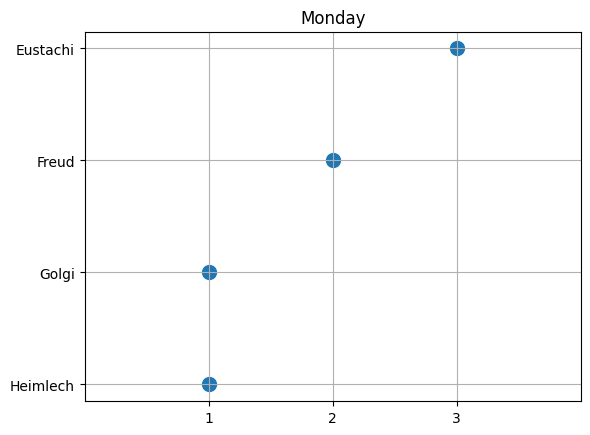

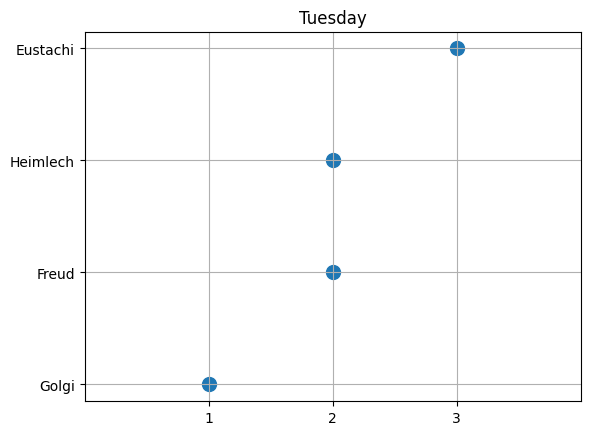

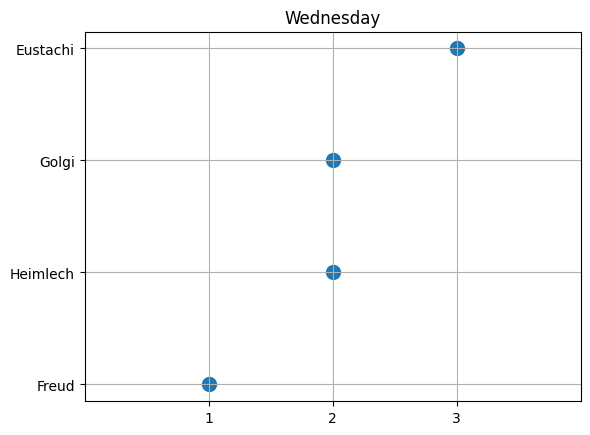

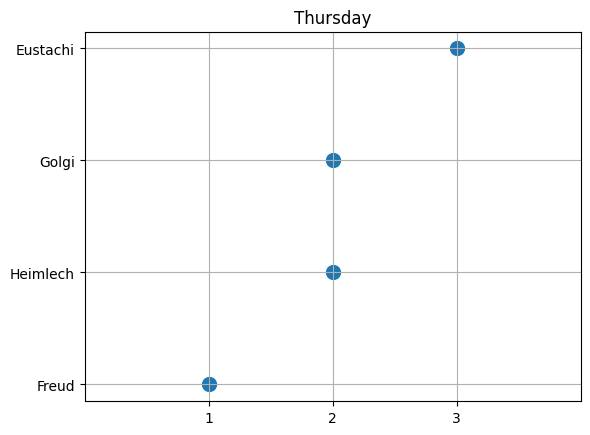

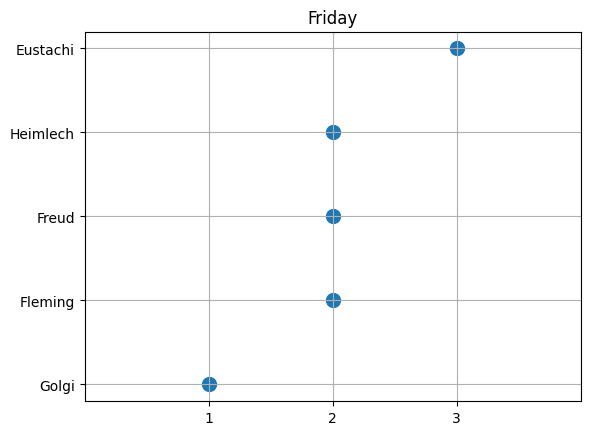

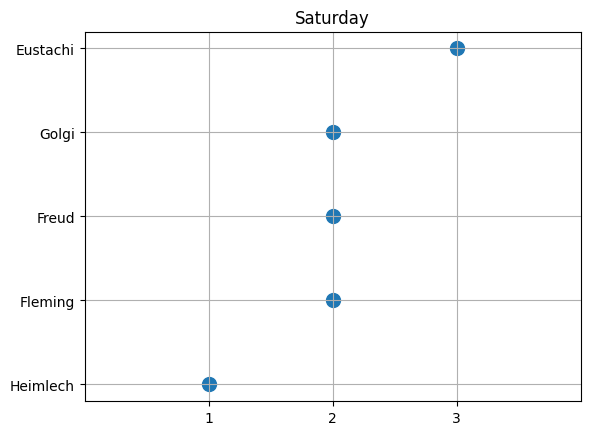

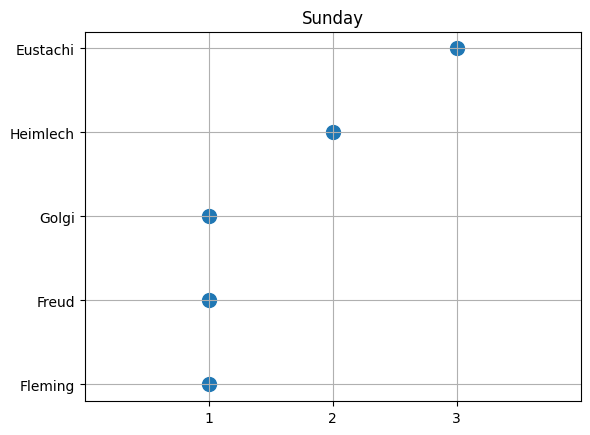

In [314]:
for i in schedule['Day'].unique():
  plt.xlim(0,4)
  plt.xticks([1,2,3])
  plt.scatter(schedule[schedule['Day'] == i]['Shift'], schedule[schedule['Day'] == i]['Doctor'], s = 100)
  plt.title(days[i])
  plt.grid()
  plt.show()

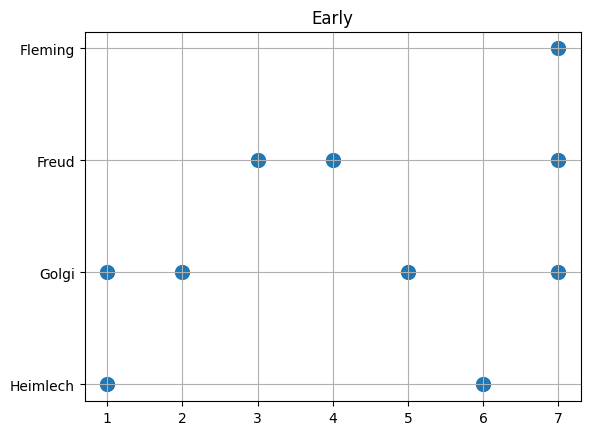

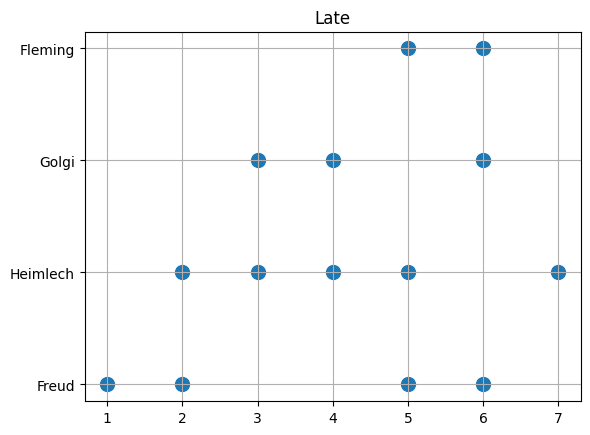

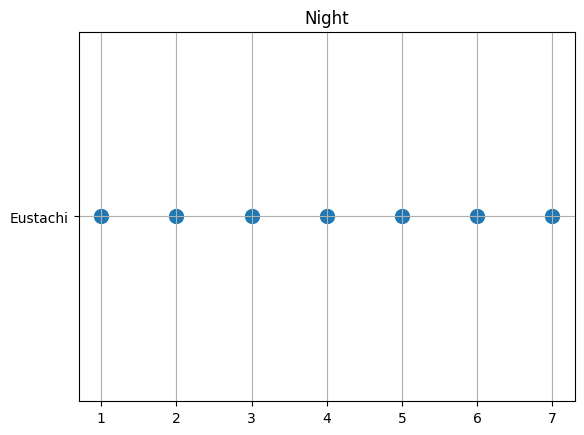

In [315]:
for i in schedule['Shift'].unique():
  #plt.xlim(0,8)
  plt.xticks([1,2,3,4,5,6,7])
  plt.scatter(schedule[schedule['Shift'] == i]['Day'], schedule[schedule['Shift'] == i]['Doctor'], s = 100)
  plt.title(shifts[i])
  plt.grid()
  plt.show()